## Подключение необходимых библиотек

In [ ]:
import numpy as np
import pandas as pd
import hashlib 
import numpy.linalg as LA
from time import time
from typing import Union, Callable, Iterable, Optional
import matplotlib.pyplot as plt
from IPython.display import Latex

from sklearn import preprocessing 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, roc_curve, roc_auc_score
from sklearn.neighbors import NearestNeighbors, DistanceMetric
from sklearn.model_selection import train_test_split, KFold

## Загрузка датасета
Все эксперименты в этой лабораторной работе проводятся на данных соревнования New York City Airbnb Open Data

In [117]:
data = pd.read_csv('/home/anabatsh/Desktop/KNN_task2/AB_NYC_2019.csv')

In [118]:
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [119]:
data.shape

(48895, 16)

In [120]:
# число значений у признаков
for col_name in data.columns:
    print(col_name, len(data[col_name].unique()))

id 48895
name 47906
host_id 37457
host_name 11453
neighbourhood_group 5
neighbourhood 221
latitude 19048
longitude 14718
room_type 3
price 674
minimum_nights 109
number_of_reviews 394
last_review 1765
reviews_per_month 938
calculated_host_listings_count 47
availability_365 366


In [121]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [122]:
data.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Как видно, по 4 признакам у элементов датасета есть пропуски. Впоследствии мы обработаем их с помощью sklearn-метода Simple Imputer. Однако перед этим создадим необхимые в будущем маски: 
1) price_mask - столбец с ценой \
2) categorical_mask - категориальные признаки \
3) target_mask - целевые признаки \
4) categorical_index - индексы столбцов категориальных признаков

In [123]:
price_mask = (data.columns == 'price')
categorical_mask = (data.dtypes == object)[~price_mask]
target_mask = ~categorical_mask
categorical_index = [i for i, val in enumerate(categorical_mask) if val == True]
n_cat_f = len(categorical_index)

Обработка пропусков NaN

In [124]:
si = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent') 
data = si.fit_transform(data) 

Формирование выборки из X - признаков объектов и их labels - y

In [125]:
X = data[:, ~price_mask]
y = data[:, price_mask]
y = y.reshape(y.shape[0])
data_vol = X.shape[0]

Впоследствии будут реализованы три собственные метрики для работы с категориальными признаками: overlap, flattened_overlap и log_overlap. Однако при попытке учить модель с помощью встроенного sklearn-метода fit, мы узрим ошибку конвертации строкового типа в численный. Было принято решение перекодировать входные категориальные данные. Поскольку массив из перекодированных признаков используется в дальнейшем как массив индексов, нормализацию проводить не будем. Гипотетически, можно было кодировать строки с помощью хэш-функции, однако тогда бы двум одинковым значениям признака в различных объектах выборки назначались бы разные хэши, во-первых, а во-вторых, пльзоваться массивом индексов из кодов признаков очень удобно.

In [126]:
le = preprocessing.LabelEncoder()
for i in (categorical_index):
    X[:,i] = le.fit_transform(X[:,i])

Разделение выборки на тестовую и обучающую.

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=241)

## Часть 1. Класс KNNRegressor
### 1.1

In [128]:
class KNNRegressor:
    def __init__(self, n_neighbors: int, metric: Union[str, Callable], mode: str = 'uniform'):
        self.__nn = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree', metric=metric)
        self.__mode = mode
        self.__n_neighbors = n_neighbors

    def fit(self, X: np.array, y: np.array) -> None:
        self.__nn.fit(X)
        self.__y_train = y
        self.__labels = np.unique(y)
        pass

    def find_kneighbors(self, X: np.ndarray):
        return self.__nn.kneighbors(X, return_distance=True)

    def estimate(self, indices: np.ndarray, distances: np.ndarray = None):
        if self.__mode == 'distance':
            weights = 1.0 / (1e-5 + distances) 
        elif self.__mode == 'uniform':
            weights = np.ones(indices.shape)
        predictions = np.mean(weights*(self.__y_train[indices]), axis=1)
        return predictions

    def predict(self, X: np.ndarray):
        distances, indices = self.find_kneighbors(X)
        return self.estimate(indices, distances)


Пример работы по 5 соседям для **целевых** признаков

In [129]:
param = {'n_neighbors': 5, 'metric': 'euclidean', 'mode': 'uniform'}
model = KNNRegressor(**param)
model.fit(X_train[:,target_mask], y_train)
pred = model.predict(X_test[:,target_mask])
pred, y_test

(array([195.0, 269.2, 190.0, ..., 212.0, 169.6, 163.2], dtype=object),
 array([129, 316, 165, ..., 200, 85, 100], dtype=object))

## Часть 2. Категориальные признаки

Для начала сформируем матрицы F, P_1, P_2, Log для каждого категориального признака:
1) F[j][x] - количество объектов тестовой выборки, на которых j-признак принимает значение x \
2) P_1[j][x] - частота, с которой j признак принимает значение x $\frac{F[j][x]}{l}$ l - число различных значений признака j \
3) P_2[j][x] = $\frac{F[j][x] - 1}{l-1}$ \
4) Log[j][x] = $\log{(F[j][x] + 1)}$ 

In [130]:
shape = (n_cat_f, data_vol)

def F_P_Log(X_train, shape, categorical_index):
    F = np.zeros((shape))
    P_1 = np.zeros((shape))
    P_2 = np.zeros((shape))
    for j, i in enumerate(categorical_index):
        val, count = np.unique(X_train[:, i], return_counts=True)
        l = len(count)
        F[j][val.astype(int)] = count
        P_1[j][val.astype(int)] = count / l
        P_2[j][val.astype(int)] = (count - 1) / (l - 1)
    Log = np.log(F + 1)
    return F, P_1, P_2, Log

### 2.1 Три функции метрики для категориальных признаков. 

In [131]:
def overlap(x, z):
    d = x!=z 
    return d.astype(int).sum()

def flattened_overlap(x, z):
    d = np.ones(len(z))
    for i, n in enumerate(d):
        if x[i]==z[i]:
            id_d = P_1[i] <= P_1[i][int(x[i])]
            d[i] = (P_1[i][id_d] * P_2[i][id_d]).sum()
    return d.sum()

def log_overlap(x, z):
    d = np.zeros(len(z))
    for i, n in enumerate(d):
        if x[i]!=z[i]:
            d[i] = Log[i][int(x[i])]*Log[i][int(z[i])]
    return d.sum()

### 2.2 Оценим качество каждой из метрик на тестовой выборке при числе соседей $k = 10$. 
(В связи с работоспосбодностью лаптопа провожу эксперименты на небольшой выборке с надеждой на легальность обобщения)

In [145]:
cat_X_train = X_train[:100,categorical_mask]
cat_X_test = X_test[:10,categorical_mask]

for i, metric in enumerate((overlap, flattened_overlap, log_overlap)):
    param = {'n_neighbors': 10, 'metric': metric, 'mode': 'uniform'}
    model = KNNRegressor(**param)
    model.fit(cat_X_train, y_train[:100])
    pred = model.predict(cat_X_test).astype(int)
    print (metric.__name__, mean_squared_error(pred, y_test[:10], squared=False), sep=' : ')

overlap : 104.0523906500951
flattened_overlap : 159.27303601049363
log_overlap : 101.1746015559241


Как видно из результатотв, самой точной метрикой оказывается log_overlap.

### 2.3 Определим наилучшее k

best k for overlap is  3
best k for flattened_overlap is  7
best k for log_overlap is  4
work_time:  2.2847607135772705


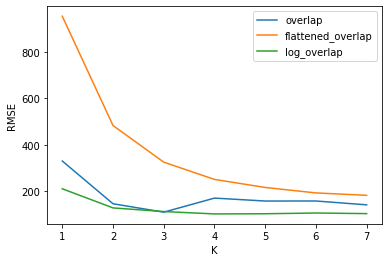

In [149]:
F, P_1, P_2, Log = F_P_Log(X_train, shape, categorical_index)

plt.xlabel('K')
plt.ylabel('RMSE')

k_test = range(1, 8)
start = time()
for metric in (overlap, flattened_overlap, log_overlap):
    res = []
    for k in (k_test):
        param = {'n_neighbors': k, 'metric': metric, 'mode': 'uniform'}
        model = KNNRegressor(**param)
        model.fit(cat_X_train, y_train[:100])
        pred = model.predict(cat_X_test).astype(int)
        res.append(mean_squared_error(pred, y_test[:10], squared=False))
    plt.plot(k_test, res, label=metric.__name__)
    print ('best k for '+metric.__name__+' is ', k_test[res.index(min(res))])
plt.legend()
print ('work_time: ', time() - start)

В результате наблюдаем, что лучшим к для overlap, flattened_overlap, log_overlap являются соответственно 3, 7 и 4 среди небольших к. 

### 2.4 Реализуем счетчики, которые заменят категориальные признаки на вещественные.

In [150]:
mean = y.mean()

target_mask = (y > mean) 
target = target_mask.astype(int)

target_train_mask = (y_train > mean) 
target_train = target_train_mask.astype(int)

target_test_mask = (y_test > mean) 
target_test = target_test_mask.astype(int)

In [151]:
def counts_successes_p(X, target_mask, shape, categorical_index, a=1, b=2):
    counts = np.zeros((shape))
    successes = np.zeros((shape))
    p = np.zeros((shape)) 
    for j, i in enumerate(categorical_index):
        val, count = np.unique(X[target_mask][:, i], return_counts=True)
        counts[j][val.astype(int)] = count
        successes[j][val.astype(int)] = count
        p[j] = (successes[j] + a)/(F[j] + b)
    return counts, successes, p

def csp_encoder(X, categorical_index, counts, successes, p):
    split = np.split(X, categorical_index, axis=1)
    for j, i in enumerate(categorical_index):
        split[j+1] = np.pad(split[j+1], ((0, 0), (2, 0)), mode='constant')
        for k, arr in enumerate((counts, successes, p)):
            split[j+1][:,k] = np.take(arr[j], X[:, i].astype(int))
    return np.concatenate(split, axis=1)


#for test
counts, successes, p = counts_successes_p(X, target_mask, shape, categorical_index, a=1, b=2)
Xcsp_test = csp_encoder(X_test, categorical_index, counts, successes, p)

#for train 1
counts, successes, p = counts_successes_p(X_train, target_train_mask, shape, categorical_index, a=1, b=2)
Xcsp_train_1 = csp_encoder(X_train, categorical_index, counts, successes, p)

Проведем фолдинг, чтобы избежать переобучения:

In [152]:
#for train 2

kf = KFold(n_splits=3)
Xcsp_arr = []
for id_1, id_2 in kf.split(X_train):
    X_other, X_one = X_train[id_1], X_train[id_2]
    target_other, target_one = target_train_mask[id_1], target_train_mask[id_2]
    counts, successes, p = counts_successes_p(X_other, target_other, shape, categorical_index, a=1, b=2)
    Xcsp_arr.append(csp_encoder(X_one, categorical_index, counts, successes, p))
Xcsp_train_2 = np.concatenate(Xcsp_arr, axis=0)

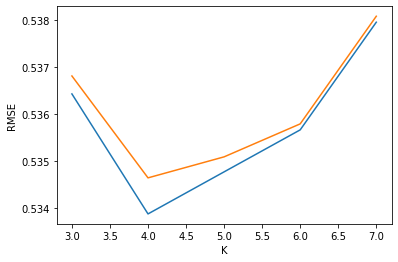

In [159]:
plt.xlabel('K')
plt.ylabel('RMSE')

k_test = np.arange(3, 8)
res_1 = []
res_2 = []

for i, k in enumerate(k_test):
    param = {'n_neighbors': k, 'metric': 'euclidean', 'mode': 'uniform'}
    model = KNNRegressor(**param)
    
    model.fit(Xcsp_train_1, target_train)
    pred_1 = model.predict(Xcsp_test).astype(int)
    res_1.append(mean_squared_error(pred_1, target_test, squared=False))
        
    model.fit(Xcsp_train_2, target_train)
    pred_2 = model.predict(Xcsp_test).astype(int)
    res_2.append(mean_squared_error(pred_2, target_test, squared=False))
    
plt.plot(k_test, res_1)
plt.plot(k_test, res_2)

Таким образом, второй вариант с фолдингом оказывается лучше. 